<base target="_blank">
In the past decades, human kind has been profiting from the assistance of Artifical Intelligence (AI) models in many areas. AI should be, and often is, helping us to make better informed decisions to support a healthy, just and thriving society. These models can be used in trivial matters like showing a marketing banner on a website, but can also pop up in scenarios with a risk of serious harm. For example, when deciding which patients could safely leave the hospital, what businesses should not get a loan from the bank or which suspects might be deemed dangerous by the judicial authorities.

For clarity, we understand that space must be created on Intensive Care Units, banks should get return on investment and crimes have to be prevented. Nevertheless, today we address a serious concern: do people in all societal groups have an equal chance of getting *what they deserve* ? Does a sick 14 year old boy have the same chance of getting the hospital care he needs as a senior woman and has a female entrepeneur the same opportunity to receive a loan as a male entrepeneur with an equally promising business model? 

Whenever such important decisions are being made based on data that has strong correlations with unknown sensitive information of people, even when not explicitely feeding this sensitive information like ethnicity to an AI model, it can implicitly withhold people belonging to certain societal groups from what they deserve. In other words, there might be no Equal Opportunity to be correctly assigned to the desirable class among people from different societal groups. In this blog we look at an example: building a model to predict whether someone will be a recidivist or not. We will work with the [COMPAS dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) on criminals in the USA, which we enrich with data on whether they commit a new crime within 2 years or not, thereby becoming a recidivist. The desired outcome for a person here is to be predicted as staying innocent in the future. We will try to give actually innocent people from different ethnicities a 'fair' chance to be predicted as such.

A whole paper could be written on the definition of 'fairness' in AI models. For a classification challenge like we face, one could for example use the metric of Demographic Parity, implying that the fraction of predicted recidivists should be equal in all ethnic groups. Though this might seem 'fair' at first glance, it bypasses the fact that the fraction of recidivists is very unlikely to be equal in different societal groups. In our dataset for example, Hispanic criminals have more often repented and stopped committing crimes. An alternative could be to look for Equalized Odds, meaning the model should perform equally well among groups in predicting who are recidivists or not. However, one could argue that we want to catch criminals as good as we can, therefore reaching for a maximum performance in identifying these future criminals without correcting for potential racial inequality, not risking to accidently deem someone as 'safe' in the name of equality. Therefore, we end up with a relaxed form of Equalized Odds, namely Equal Opportunity. This means that the average chance to correctly be predicted as innocent within every ethnic group must be equal.

Continue reading and find out how the [Fairlearn Python package](https://fairlearn.org/) can help to make a prediction model more 'fair' in terms of giving Equal Opportunities to people from different societal groups.

### Import Python Packages
We start by importing Pandas, Numpy and Seaborn to load and explore our data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Set random seed
To make the results in this notebook that depend on random number generators reproducible, we set the random seed.

In [2]:
seed = 42

### Load and Explore Data
We load a Pandas Dataframe that is constructed of the original COMPAS dataset and the Cox dataset on recidivism or not within 2 years. We have deduplicated double records and encoded text data (for example on ethnicity) into numerical variables.

In [3]:
df = pd.read_pickle('230113_DataFrame_Fairlearn.pkl')

We have 4667 entries, of which 1735 correspond to recidivists (37%). To fit a model for predicting 'Recidivism', we use the age, number of prior crimes, severity of the original charge two years ago, marital status and gender of the person. <br> Ethnicity is used to verify Equality of Opportunity among ethnic groups after fitting the model. <br> The dataset has 54% Afro-American, 31% Caucasian, 9% Hispanic and 6% other people.

In [4]:
print(f"{df.columns.values} \n")
print(f"{round(df[['Afro-Americans','Caucasian','Hispanic']].mean(),2)} \n")
print(f"{round(1-df[['Afro-Americans','Caucasian','Hispanic']].sum(axis=1).mean(),2)} \n")

['Recidivism' 'Age' 'Prior_Crimes' 'Original_Charge_Scale' 'Married'
 'Female' 'Afro-Americans' 'Caucasian' 'Hispanic'] 

Afro-Americans    0.54
Caucasian         0.31
Hispanic          0.09
dtype: float64 

0.06 



In the table below, we see that the number of recidivists is a little unbalanced between groups.
In this particular dataset for example, the proportion of Afro-Americans is higher in the group of recidivists than in the group of criminals that weren't charged again within 2 years.

In [5]:
round(df.groupby('Recidivism').mean().transpose(),2)

Recidivism                 0      1
Age                    29.72  28.30
Prior_Crimes            2.25   4.43
Original_Charge_Scale   4.26   4.43
Married                 0.10   0.07
Female                  0.24   0.15
Afro-Americans          0.50   0.60
Caucasian               0.33   0.28
Hispanic                0.10   0.07

We see a moderate correlation in this particular dataset of Prior_Crimes with both Recidivism and the Afro-American ethnicity. This yields the risk that when creating a model to predict Recidivism with Prior_Crimes, this Prior_Crimes could become a [proxy](https://aiblindspot.media.mit.edu/discrimination_by_proxy.html) for Afro-American whereby an implicit relation arises between Ethnicity and Recidivism resulting in significantly different results for people from different ethnic groups. We shall see what this will imply for 'fairness'.

<AxesSubplot:>

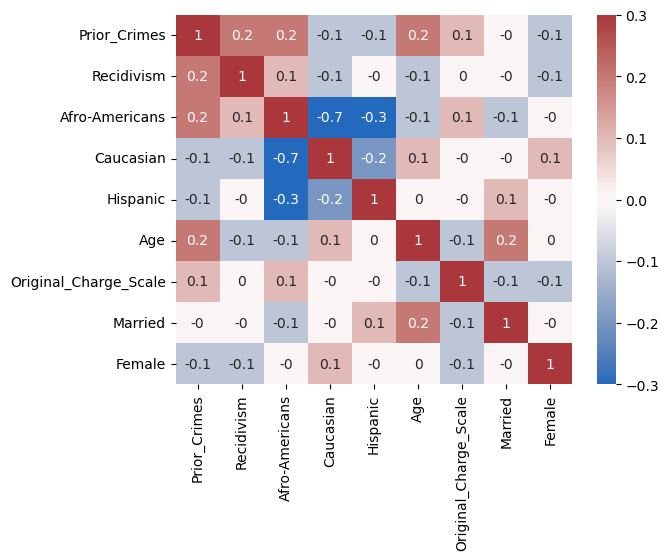

In [6]:
cor_col_order = ['Prior_Crimes','Recidivism', 'Afro-Americans', 'Caucasian', 'Hispanic', 'Age', 
                 'Original_Charge_Scale','Married','Female']
dfcor = round(df[cor_col_order].corr(),1)
_ = sns.heatmap(dfcor,cmap='vlag',vmin=-0.3,vmax=0.3,annot=True)

### Split Train and Test Set
We split the data in 5 batches of 20% to train the model (on 4 batches) and test predictive performance (1 batch) 5 times and therefore with cross-validation draw conclusions that are not based on only one random sampling of the data.
To do so, we import the ```sklearn``` package.

In [7]:
import sklearn as sk
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import KFold

cv = KFold(n_splits = 5, random_state = seed, shuffle = True)

dff, dfv = model_selection.train_test_split(df,test_size=0.2,random_state = seed)

### Select features
We select known covariates to fit a baseline model for recidivism, note that we do not include ethnicity as a predictor. 

In [8]:
xcols = ['Prior_Crimes','Married', 'Age', 'Original_Charge_Scale','Female']
ethnicities = ['Afro-Americans','Caucasian','Hispanic']

dfx = df[xcols]
dfe = df[ethnicities]
dfy = df['Recidivism']

### Fit Random Forest Model

We choose to use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as a relatively simple Machine Learning algorithm to create a predictive model between our covariates and Recidivism.

We use the cross-validation to prevent drawing a conclusion based on one random sample in the data.

We collect performance metrics, information about the predictive power of each covariate and fairness metrics.

To collect these fairness metrics, we import the ```fairlearn``` package and specifically the function ```MetricFrame```.

In [9]:
import fairlearn as fl
from fairlearn.metrics import MetricFrame as MF

After running the following code, we will go over each of these results.

In [24]:
model = RFC(n_estimators = 100, max_depth = 5, max_features = 'sqrt',random_state = seed)
dfperf = pd.DataFrame(index = ['Accuracy','AUROC'] ,columns = range(5))
dffi = pd.DataFrame(index = xcols,columns = range(5))
df_tnr = pd.DataFrame(index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=range(5))
df_tpr = pd.DataFrame(index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=range(5))



for i, (train, test) in enumerate(cv.split(df)):
    model.fit(dfx.iloc[train,:],dfy[train])
    yvpred = model.predict(dfx.iloc[test,:])
    dfperf.loc['Accuracy',i] = sk.metrics.accuracy_score(dfy[test],yvpred)
    dfperf.loc['AUROC',i] = sk.metrics.roc_auc_score(dfy[test],yvpred)
    dffi.iloc[:,i] =  (pd.DataFrame(data = model.feature_importances_,index=xcols,columns=['Feature Importance %']))
    tnr = MF(metrics=fl.metrics.true_negative_rate,y_true = dfy[test], y_pred = yvpred,sensitive_features=dfe.iloc[test,:])
    df_tnr.iloc[:,i] = pd.DataFrame(data=[tnr.overall,tnr.by_group[1][0][0],tnr.by_group[0][1][0],tnr.by_group[0][0][1],tnr.by_group[0][0][0]],index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=['TNR %'])
    
    
    tpr = MF(metrics=fl.metrics.true_positive_rate,y_true = dfy[test], y_pred = yvpred,sensitive_features=dfe.iloc[test,:])
    df_tpr.iloc[:,i] = pd.DataFrame(data=[tpr.overall,tpr.by_group[1][0][0],tpr.by_group[0][1][0],tpr.by_group[0][0][1],tpr.by_group[0][0][0]],index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=['TPR %'])

av_tpr = round(pd.DataFrame(data = df_tpr.mean(axis=1),index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'],columns=['TPR %'])*100).astype(int)


### Attain Performance

The benchmark for accuracy is the fraction of the majority outcome. 

In [18]:
bench = max(1-df['Recidivism'].mean(),df['Recidivism'].mean())
print(f'Benchmark:  {round(bench,2)} \n')

Benchmark:  0.63 



Accuracy (the fraction of correct predictions) is the first performance metric we look at. This baseline model has a mediocre performance with an accuracy of 0.67, slightly above benchmark. 

In [19]:
av_acc = dfperf.loc['Accuracy',:].mean()
print(f'Accuracy: {round(av_acc,2)} (so {int(round(100*(av_acc - bench)))}%-point higher than benchmark)\n')

Accuracy: 0.67 (so 4%-point higher than benchmark)



A more sophisticated performance metric for classification (recidivist or not) is the Area Under the Receiver Operating Curve ([AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)). It is a combination of how well the model can classify the actual recidivists as such and how precise it is in not classifying the innocent people as recidivists. An AUC of 0.5 resembles a randomly guessing model. We only achieve an AUC of 0.63, which is mediocre. Of course we could optimize this model further by tuning the hyperparameters or to use feature engineering to add additional features. However, for the purpose of this tutorial notebook we focus on the fairness of the model instead of optimizing its performance. 

In [20]:
av_auroc = dfperf.loc['AUROC',:].mean()
print(f'Area under the ROC: {round(av_auroc,2)} (Our {round(av_auroc,2)} is only slightly better than 0.5)')

Area under the ROC: 0.6 (Our 0.6 is only slightly better than 0.5)


### How important is the contribution of each covariate to the model performance

The number of prior crimes is by far the most important covariate in building the prediction model (58% average Feature Importance).

In [21]:
fis = (pd.DataFrame(data = dffi.mean(axis=1),index=xcols,columns=['Feature Importance %'])*100).astype(int)
fis.sort_values('Feature Importance %',ascending=False)

Feature Importance %
Prior_Crimes                             58
Age                                      25
Original_Charge_Scale                     7
Female                                    7
Married                                   1

### What is the chance innocent people are predicted as such (True Negative Rate)

Many performance metrics exist and we focus on the True Negative Rate (TNR). In our case, this is the fraction of innocent people that is predicted as such. So, it is the statistical equivalent of opportunity level of getting the desired outcome in each group.

Innocent Afro-Americans in our dataset have an 84% chance of being predicted as such, but this is 6% higher for Caucasians (90%) and 8% for Hispanics (92%).

Although these percentages are all quite high, they also imply that an innocent Afro-American has a 16% chance to be predicted as a recidivist, which is twice as large as for Hispanics (8%). Arguably, this is 'unfair', as this 16% is innocent.

In [22]:
av_tnr = round(pd.DataFrame(data = df_tnr.mean(axis=1),index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'],columns=['TNR %'])*100).astype(int)
av_tnr

TNR %
Overall            87
Afro-Americans     84
Caucasian          90
Hispanic           92
Other              90

### Give innocent people Equality of Opportunity to be predicted as such

From the ```fairlearn``` package, we import the mitigator ```ExponentiatedGradient``` and equality constraint ```FalsePositiveRateParity``` for optimizing the model to equalize among groups the chance for innocent people to be regarded as such. In this optimization process, the relations in the Random Forest between covariates and Recidivism will be refitted, hopefully leading to more fair results, while not having a too negative impact on the predictive power of the Random Forest.

We have seen a positive correlation between the number of prior crimes and being Afro-American and that Prior_Crimes had the hightest Feature Importance. Therefore, opportunities especially lie in refitting the relations between Prior_Crimes and Recidivism to give Afro-Americans a higher TNR.

The [```ExponentiatedGradient```](http://proceedings.mlr.press/v80/agarwal18a.html) is a mitigating algorithm that incorporates fairness constraints into a cost function that should be minimized while fitting a given classifier (like our Random Forest). A few predefined fairness constraints exist in the ```fairlearn``` package. For example, to equalize the True Negative Rate, we can tell the ```ExponentiatedGradient``` to equalize the opposite of TNR, namely False Positive Rate (this is 1 - TNR). If this False Positive Rate is equalized, also the TNR will be equal. Therefore, we use ```FalsePositiveRateParity``` as the constraint for the mitigator.

In [25]:
from fairlearn.reductions import ExponentiatedGradient as EG, FalsePositiveRateParity as FPRP

We fit the Random Forest and iteratively improve it 100 times on training data to give innocent people in the training set Equal Opportunity. It has to be seen if this Equality of Opportunity will also be attained when deploying the model on the test data.

In [26]:
m_dfperf = pd.DataFrame(index = ['Accuracy','AUROC'] ,columns = range(5))
m_dffi = pd.DataFrame(index = xcols,columns = range(5))
m_df_tnr = pd.DataFrame(index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=range(5))
m_df_tpr = pd.DataFrame(index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=range(5))

for i, (train, test) in enumerate(cv.split(df)):
    classifier = RFC(n_estimators = 100, max_depth = 5, max_features = 'sqrt',random_state = seed)
    constraint = FPRP()
    np.random.seed(seed) #We set the random seed so that random results can be replicated
    mitigator = EG(classifier,constraint,eps=0.01,max_iter = 100)
    mitigator.fit(dfx.iloc[train,:],dfy[train],sensitive_features=dfe.iloc[train,:])
    yvpred = mitigator.predict(dfx.iloc[test,:])
    m_dfperf.loc['Accuracy',i] = sk.metrics.accuracy_score(dfy[test],yvpred)
    m_dfperf.loc['AUROC',i] = sk.metrics.roc_auc_score(dfy[test],yvpred)
    m_dffi.iloc[:,i] =  (pd.DataFrame(data = model.feature_importances_,index=xcols,columns=['Feature Importance %']))
    tnr = MF(metrics=fl.metrics.true_negative_rate,y_true = dfy[test], y_pred = yvpred,sensitive_features=dfe.iloc[test,:])
    m_df_tnr.iloc[:,i] = pd.DataFrame(data=[tnr.overall,tnr.by_group[1][0][0],tnr.by_group[0][1][0],tnr.by_group[0][0][1],tnr.by_group[0][0][0]],index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=['TNR %'])
    tpr = MF(metrics=fl.metrics.true_positive_rate,y_true = dfy[test], y_pred = yvpred,sensitive_features=dfe.iloc[test,:])
    m_df_tpr.iloc[:,i] = pd.DataFrame(data=[tpr.overall,tpr.by_group[1][0][0],tpr.by_group[0][1][0],tpr.by_group[0][0][1],tpr.by_group[0][0][0]],index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'], columns=['TPR %'])

### Results after mitigation

The accuracy attained by this new model is the same as for the original model and the AUROC is only slighlty lower (0.59 instead of 0.60), so we lose little predictive power with the mitigated model. Also, no large differences exist in the Feature Importances between the original and mitigated model. We are most interested in seeing how well the mitigated model can equalize the opportunities for innocent people to be regarded as such, without losing True Negative Rate for any group.

In [27]:
m_av_acc = m_dfperf.loc['Accuracy',:].mean()
print(f'Accuracy: {round(m_av_acc,2)} (so {int(round(100*(m_av_acc - bench)))}%-point higher than benchmark)\n')
m_av_auroc = m_dfperf.loc['AUROC',:].mean()
print(f'Area under the ROC: {round(m_av_auroc,2)} (Our {round(m_av_auroc,2)} is only slightly better than 0.5)\n')
m_fis = (pd.DataFrame(data = m_dffi.mean(axis=1),index=xcols,columns=['Feature Importance %'])*100).astype(int)
m_fis.loc[:,'Feature Importance % (old model)'] = fis['Feature Importance %']
m_fis.sort_values('Feature Importance %',ascending=False)

Accuracy: 0.67 (so 4%-point higher than benchmark)

Area under the ROC: 0.59 (Our 0.59 is only slightly better than 0.5)



Feature Importance %  Feature Importance % (old model)
Prior_Crimes                             57                                58
Age                                      25                                25
Female                                    8                                 7
Original_Charge_Scale                     7                                 7
Married                                   1                                 1

The chance for innocent people to be regarded as such has on average increased from 87% to 91% and the gaps between ethnic groups have also decreased on average (from 8% to 4% between Afro-Americans and Hispanics), though not fully closing.



In [29]:
m_av_tnr = round(pd.DataFrame(data = m_df_tnr.mean(axis=1),index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'],columns=['TNR %'])*100).astype(int)
m_av_tnr.loc[:,'TNR % (old model)'] = av_tnr['TNR %']
m_av_tnr

TNR %  TNR % (old model)
Overall            91                 87
Afro-Americans     90                 84
Caucasian          93                 90
Hispanic           94                 92
Other              92                 90

### "All magic comes with a price"

Though the predictive performance didn't drop much overall, it didn't increase either, but the TNR did. This implies that the fraction of recidivists correctly being predicted, the True Positive Rate, must have decreased. It indeed did so for all ethnic groups (overall from 33% to 27%) and especially within the group of Afro-Americans (from 39% to 32%).

In [30]:
m_av_tpr = round(pd.DataFrame(data = m_df_tpr.mean(axis=1),index=['Overall','Afro-Americans','Caucasian','Hispanic','Other'],columns=['TPR %'])*100).astype(int)
m_av_tpr.loc[:,'TPR % (old model)'] = av_tpr['TPR %']
m_av_tpr

TPR %  TPR % (old model)
Overall            27                 33
Afro-Americans     32                 39
Caucasian          18                 23
Hispanic           26                 28
Other              17                 19

### Conclusion

With our dataset, using the ```fairlearn``` package to retrain the model 100 times not only helped approaching Equality of Opportunity for innocent people among several ethnic groups in the validation data, but also increased the opportunity for innocent people to be predicted as such in all groups.

The cost of the mitigation was limited in terms of overall predictive performance, as the accuracy on the validation data was equal for both models and the AUROC only decreased from 60% in the original model to 59% after mitigation. Nevertheless, the new model performed less in correctly predicting the recidivists, as the TPR dropped from 33% to 27%.

The most important achievement of the mitigator was that the chance to be erroneously predicted as recidivist for Afro-Americans declined from 16% to 10%. Our new model did not only make the results more 'fair', but also increased opportunities to correctly be regarded as innocent for all groups involved. 

### Discussion

One could focus on Equality a lot, but the result that benefits the innocent people as individuals the most, is not being seen as recidivist. If our mitigation resulted in the gap in TNR staying 8% (and the TPR also dropping from 33% to 27%), but this was because of the TNR became 100% for Hispanics and 92% for Afro-Americans, it would arguably have been a societal better result than what we achieved now with a TNR of 94% for Hispanics and 90% for Afro-Americans.

By telling the mitigating algorithm which people have which ethnicity, so the group with a lower opportunity can benefit, you are using ethnic data. It could be argued that this is racial discrimination. What if indeed increasing the TNR of Afro-Americans from 84% to 90% is accompanied by a decrease in TNR for Hispanics from 92% to 91%? Is it then still allowed to use the mitigator, since using it with racial data has a negative effect on people from a certain ethnic group?

Also, the decrease in performance on correctly predicting recidivists raises the question how much of this loss is allowed in name of Equal Opportunities among ethnic groups. Do the societal costs of losing 6% TPR outweigh increasing and equalizing the opportunities for innocent people among different groups?

In this blog I showed how you are able to detect possible unfairness in models and what can be done to prevent possible harmfull outcomes. Please feel free to use this example to investigate possible unifairness in your own models. However, what is considered 'fair' is not always clear upfront, therefore a technical solution is just one part of the puzzle. So you might find yourself discussing the definition of 'fair' within your team, which is valuable on its own. 